In [1]:
def mturk_analysis(file_path, list_turker_counts):
    """ 
Takes in a path to a selected file and a list of numbers representing different mechanical turk votes
and saves a figure of subplots for the distributions of label asssignments for each number of turkers in the list. 
It also saves csv files for the analysis of the label assignments (i.e. std, avg, etc.), a csv of all the label
and sentence assignments for the entire set, and a csv of label and sentence assignments that are to be used 
for the training and testing sets. All of this is saved to the file path where the input file was selected from.
    """
    
    data_set = pd.read_csv(file_path[0]).loc[ : , ["Input.text","Answer.Label", "Answer.Severity", "Answer.isStress"]]
    iteration = 1
    plt.figure(figsize=(10, 20))
    for number in list_turker_counts:
        mturk_main_dict = mturk_auto(data_set, number)
        labelSentence_dict = labelsent_dict(mturk_main_dict)
        training_set, testing_set = train_test_set(labelSentence_dict)
        make_plot(labelSentence_dict, len(list_turker_counts), iteration, number)
        pd.DataFrame(mturk_main_dict).to_csv("Main turk analysis of " + str(number) + " turkers" + ".csv", index=False, header=True)
        pd.DataFrame(labelSentence_dict).to_csv("Labels and Sentences for " + str(number) + " turkers" + ".csv", index=False, header=True)
        pd.DataFrame(training_set).to_csv("training labels & sentences " + str(number) + "turkers" + ".csv", index=False, header=True)
        pd.DataFrame(testing_set).to_csv("testing labels & sentenes " + str(number) + " turkers" + ".csv", index=False, header=True)
        iteration += 1
    plt.savefig("INSERT FIG NAME HERE " + "turkers" + ".png", bbox_inches='tight')

In [2]:
def labelsent_dict(turk_analysis_dict):
    """ 
    takes in a dictionary that is in the format of the dictionary returned from the turk analysis 
    and returns a dictionary that is just label and sentence assignments. 
    """
    # This is putting dictionary in desired form of simply just labels and corresponding sentences
    counting_dict = {'label': [], 'sentence': []}
    for i in range(len(turk_analysis_dict['input_text'])):
        counting_dict['label'].append(turk_analysis_dict['labels'][i]) # labels is the list of all label assignments
        counting_dict['sentence'].append(turk_analysis_dict['input_text'][i]) # actual sentence being assigned a labal
    return counting_dict      

In [3]:
def csv_form(dictionary_labels_sentences):
    """
 This takes in a dictionary that is in the form of labels as keys and a list of sentences as values
 and returns a dictionary with a key for labels with a value of a list of labels and a key for sentence
 with a value of a list of sentences corresponding with the label values under the label key at each index. 
    """
    
    csv_ready_dict = {'label': [], 'sentence': []}
    for label in dictionary_labels_sentences:
        for sentence in dictionary_labels_sentences[label]:
            csv_ready_dict['label'].append(label)
            csv_ready_dict['sentence'].append(sentence)
    return csv_ready_dict

In [4]:
def train_test_set(label_sent_dict):
    """ 
    Takes the dictionary that was created from the labelsent_dict and creates
    a training and testing set.
    """
    
    # Create a dictionary that has labels as keys and list of assigned sentences as values
    starting_dict = {}
    for i in range(len(label_sent_dict['label'])):
        if label_sent_dict['label'][i] not in starting_dict:
            starting_dict[label_sent_dict['label'][i]] = []
        starting_dict[label_sent_dict['label'][i]].append(label_sent_dict['sentence'][i])
    
    # Create training dictionary and then take away the labels and sentences we want to use for testing dictionary
    training_dict = csv_form(starting_dict)
    testing_dict = {'label': [], 'sentence': []}
    
    for label in starting_dict:
        # 0.2 because we want 20% of the words for the testing dictionary
        testing_count = 0.2 * len(starting_dict[label])
        count_added = 0
        while (count_added < testing_count):
            choice = np.random.choice(starting_dict[label])
            starting_dict[label].remove(choice)
            testing_dict['label'].append(label)
            testing_dict['sentence'].append(choice)
            choice_position = training_dict['sentence'].index(choice)
            # deleting the values at certain indeces to make sure we remove them at the right spot
            del training_dict['sentence'][choice_position] 
            del training_dict['label'][choice_position]
            count_added += 1
    return training_dict, testing_dict

In [5]:
def make_plot(label_sent_dict, total_count, number, turker_num):
    """
    This function takes in a dictionary in the form of the dictionary returned from labelsent_dict,
    the number of turker votes being considered (i.e. [1, 3, 5] would equal 3 for total_count),
    the amount of times this iteration of this function has been called, and the current turker vote
    amount that is being considered. This returns an annotated figure of subplots that allow for the user
    to observe the differences in label assignment with different numbers of turkers.
    """
    # The plot can only be made from values (or "counts") so this counts the number of label assignments per label
    counts_dict = make_count_dict(label_sent_dict)
    
    # creates the values for the plot
    keys = list(counts_dict.keys())
    values = list(counts_dict.values())
    
    # Creates the subplot at certain region in figure
    plt.subplot(total_count, 1, number)
    plt.title("Plot for " + str(turker_num) + " turkers") # helps differentiate each subplot 
    plt.barh(keys, values)
    
    # plots the values of the bars on the plot
    for index, value in enumerate(values):
        plt.text(value, index, str(value))

In [6]:
def print_stats(percent_list):
    stat_list = []
    for percent in percent_list:
        stat_list.append(float(percent.strip('%')))
    print("Standard Deviation: " + str(np.std(stat_list)))
    print("Average: " + str(np.average(stat_list)))
    print("Median: " + str(np.median(stat_list)))    

In [7]:
def sentence_occurrence_count(data_frame):
    """
    This takes in a dataframe that was produced from reading in the csv file that was selected
    and returns the number of sentence repetitions per sentence. 
    Essentially how many turker votes per sentence there are.
    """
    data_frame = data_frame['Input.text'].tolist() # creates list of sentences in the csv file
    count = 0
    last = data_frame[0]
    while data_frame[count] == last:
        count += 1
    return count

In [8]:
def label_stressor(list_label):
    """ 
    This takes in a list of label assignments and returns the most common assignment
    and the percent of the set population that voted for that assignment.
    """
    # Create a dict of counts per label vote from turker
    label_dict = {}
    for label in list_label:
        if label not in label_dict:
            label_dict[label] = 0
        label_dict[label] += 1
   
    max_key = max(label_dict, key=label_dict.get) # how to find key wih max value
    percent = (label_dict[max_key]/len(list_label)) * 100 # convert to percent
    return max_key, percent

In [9]:
def is_stressor(list_stressor):
    """
    this takes in a list of stressor votes (i.e. is a stressor OR not a stressor) and returns 'True' 
    if the amount of votes for if it were a stressor were the majority and False otherwise. 
    It also returns the percent of the set population that elected the winning vote.
    """
    stressor_conf = 0
    for stressor in list_stressor:
        stressor_conf += stressor
    value = stressor_conf/len(list_stressor)
    
    # making sure that half is rounded up to 1
    if value == 0.5:
        value = 1
        
    if round(value) == 1: # if its greater than 50% it will round to 1, else 0
        return 'True', (stressor_conf/len(list_stressor)) * 100
    return 'False', ((len(list_stressor) - stressor_conf)/len(list_stressor)) * 100    

In [10]:
def mturk_auto(data_frame, number):
    """ 
    This Function takes in a DataFrame and a number of turker votes being considered at this iteration.
    Returns a dictionary that contains the label assignments with corresponding sentences, and analysis
    of severity of each stressor. 
    
    """
    # These are the things we want in our dictionary
    mturk_dict = {'input_text':[] ,'avg_severity':[], 'median_severity':[], 'SD_severity': [], 'is_stressor': [], 'label_conf': [], 'labels': [], 'is_stressor_conf': []}
    
    # make everyrthing a list so it is easier to iterate over
    label_list = data_frame["Answer.Label"].tolist()
    severity_list = data_frame["Answer.Severity"].tolist()
    stressor_list = data_frame["Answer.isStress"].tolist()
    input_text = data_frame["Input.text"].tolist()
    
    sentence_count = sentence_occurrence_count(data_frame) # How many turkers vote on a single sentence
    count = len(label_list)/sentence_count # How many groups of sentences are there to loop through
    
    last = 0
    for i in range(int(count)):
        place = last
        
        #Create sublists to determine the majority vote
        label_set = label_list[place: place + number]
        stressor_set = stressor_list[place : place + number]
        severity_set = severity_list[place : place + number]
        
        #Get the label and stressor assignment and corresponding confidence values
        max_key, percent = label_stressor(label_set)
        boolean, confidence = is_stressor(stressor_set)
        
        #Append all variables to the main dictionary
        mturk_dict['labels'].append(max_key)
        mturk_dict['label_conf'].append(str(percent) + '%')
        if boolean == 'True':
            mturk_dict['is_stressor'].append("is stressor")
        else: 
            mturk_dict['is_stressor'].append("Not a stressor")
        mturk_dict['is_stressor_conf'].append(str(confidence) + '%') # To make it look better on csv or excel
        mturk_dict['avg_severity'].append(str(np.average(severity_set)) + '%')
        mturk_dict['median_severity'].append(str(np.median(severity_set)) + '%')
        mturk_dict['SD_severity'].append(str(round(np.std(severity_set), 2)) + '%') # rounding to two integers looks better
        mturk_dict['input_text'].append(input_text[place])
        last = place + sentence_count
    return mturk_dict

In [11]:
def make_count_dict(dict_labels_sent):
    """
    Takes in a dictionary of the form that is returned from the labelsent_dict function
    and returns a dictionary that has the keys as labels and counts of the number of times
    that label has been assigned as the values.
    """
    counts_of_labels = {}
    for label in dict_labels_sent['label']:
        if label not in counts_of_labels:
            counts_of_labels[label] = 0
        counts_of_labels[label] += 1
    return counts_of_labels

In [12]:
import pandas as pd
import numpy as np
import math
import statistics
import operator
import matplotlib.pyplot as plt
import traitlets
from IPython.display import display
from ipywidgets import widgets
from tkinter import Tk, filedialog


class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self, *args, **kwargs):
        """Initialize the SelectFilesButton class."""
        super(SelectFilesButton, self).__init__(*args, **kwargs)
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.
        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
my_button = SelectFilesButton()
my_button


SelectFilesButton(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

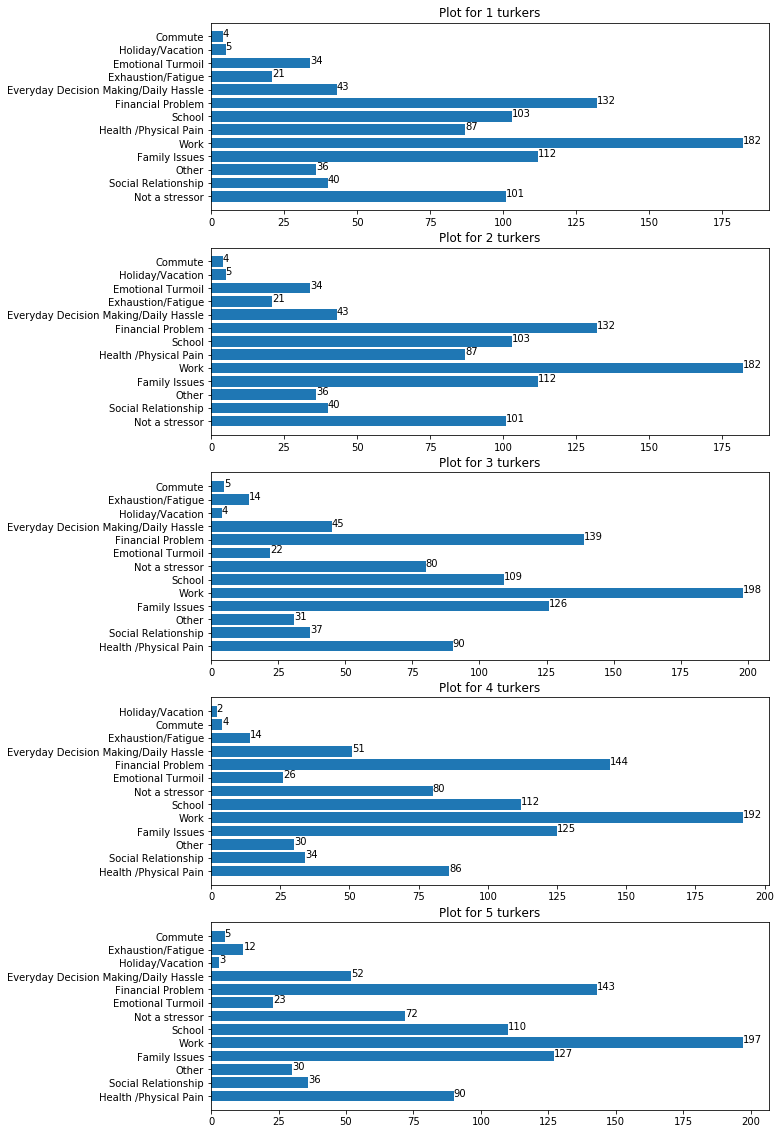

In [19]:
# Make sure that the second argument parameter is a list. Even if it is one number, put it in brackets. 
mturk_analysis(my_button.files, [1, 2, 3, 4, 5])